In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.tokenize import word_tokenize
from transformers import AutoModel, AutoTokenizer
import torch
from sklearn.metrics.pairwise import cosine_similarity

In [8]:
# read genereted  and real  data

#genereted data
data_gpt4o_mini = pd.read_csv('gpt4mini.csv')
data_gpt4o= pd.read_csv('gpt4o.csv')

texts = data_gpt4o_mini['Text']
labels = data_gpt4o_mini['label']

texts_o = data_gpt4o['Text']
labels_o = data_gpt4o['label']

llm_data = pd.concat([data_gpt4o_mini, data_gpt4o])

texts_all = llm_data['Text']
labels_all = llm_data['label']

#Real Data

real_data = pd.read_csv('Arabic_dialects_Larger.csv')
texts_real = real_data ['sent']
labels_real = real_data['label']


In [5]:
# Load BERT tokenizer and model
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Function to get embeddings
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Compute embeddings for real and synthetic texts grouped by label
labels = real_data['label'].unique()
real_embeddings = {label: [get_embedding(text) for text in real_data[real_data['label'] == label]['sent']] for label in labels}
synthetic_embeddings = {label: [get_embedding(text) for text in llm_data[llm_data['label'] == label]['Text']] for label in labels}

# Calculate average cosine similarity between real and synthetic data for each label
for label in labels:
    real_emb_list = real_embeddings[label]
    synthetic_emb_list = synthetic_embeddings[label]

    # Ensure both real and synthetic lists have data
    if real_emb_list and synthetic_emb_list:
        # Calculate cosine similarity between all pairs of real and synthetic embeddings for this label
        similarities = cosine_similarity(real_emb_list, synthetic_emb_list)
        avg_similarity = np.mean(similarities)
        print(f"Average cosine similarity between real and synthetic texts for label '{label}': {avg_similarity:.4f}")
    else:
        print(f"Not enough data for label '{label}' to calculate similarity.")


Average cosine similarity between real and synthetic texts for label 'Iraqi': 0.5857
Average cosine similarity between real and synthetic texts for label 'Gulf': 0.5742
Average cosine similarity between real and synthetic texts for label 'Maghrebi': 0.6064
Average cosine similarity between real and synthetic texts for label 'Levantine': 0.5887
Average cosine similarity between real and synthetic texts for label 'Egyptian': 0.5907


In [10]:
# Calculate Word Count for Real and LLM-Generated Data
real_data['word_count'] = real_data['sent'].apply(lambda x: len(str(x).split()))
llm_data['word_count'] = llm_data['Text'].apply(lambda x: len(str(x).split()))

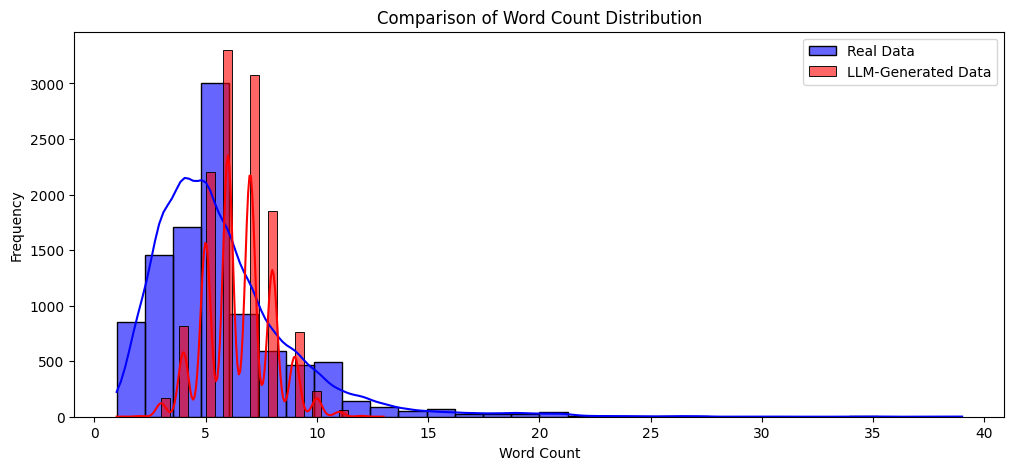

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting Word Count Distribution
plt.figure(figsize=(12, 5))
sns.histplot(real_data['word_count'], bins=30, kde=True, color='blue', label='Real Data', alpha=0.6)
sns.histplot(llm_data['word_count'], bins=30, kde=True, color='red', label='LLM-Generated Data', alpha=0.6)
plt.title('Comparison of Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()


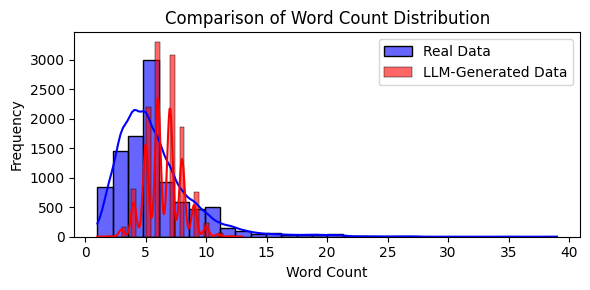

In [22]:
# Plotting Word Count Distribution
plt.figure(figsize=(6, 3))  # Adjusted figure size to 6 inches wide by 3 inches tall
sns.histplot(real_data['word_count'], bins=30, kde=True, color='blue', label='Real Data', alpha=0.6)
sns.histplot(llm_data['word_count'], bins=30, kde=True, color='red', label='LLM-Generated Data', alpha=0.6)
plt.title('Comparison of Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()  # Ensures the layout fits within the figure size
# Save the figure
plt.savefig('figures/word_count_distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()



In [18]:
# Calculate average word count for each dataset
average_words_real = real_data['word_count'].mean()
average_words_llm = llm_data['word_count'].mean()

print(f"Average word count (Real Data): {average_words_real}")
print(f"Average word count (LLM-Generated Data): {average_words_llm}")

Average word count (Real Data): 5.7457779554311985
Average word count (LLM-Generated Data): 6.47936


In [23]:
from collections import Counter
import itertools

# Calculate word lists for both datasets
real_words = list(itertools.chain(*real_data['sent'].str.split()))
llm_words = list(itertools.chain(*llm_data['Text'].str.split()))

# Count unique words and calculate TTR
real_unique_words = len(set(real_words))
llm_unique_words = len(set(llm_words))
ttr_real = real_unique_words / len(real_words)
ttr_llm = llm_unique_words / len(llm_words)
print('real_unique_words',real_unique_words)

print('llm_unique_words',llm_unique_words)
print(f"Vocabulary Size - Real Data: {real_unique_words}, Type-Token Ratio: {ttr_real:.3f}")
print(f"Vocabulary Size - LLM-Generated Data: {llm_unique_words}, Type-Token Ratio: {ttr_llm:.3f}")


real_unique_words 14587
llm_unique_words 27582
Vocabulary Size - Real Data: 14587, Type-Token Ratio: 0.254
Vocabulary Size - LLM-Generated Data: 27582, Type-Token Ratio: 0.341


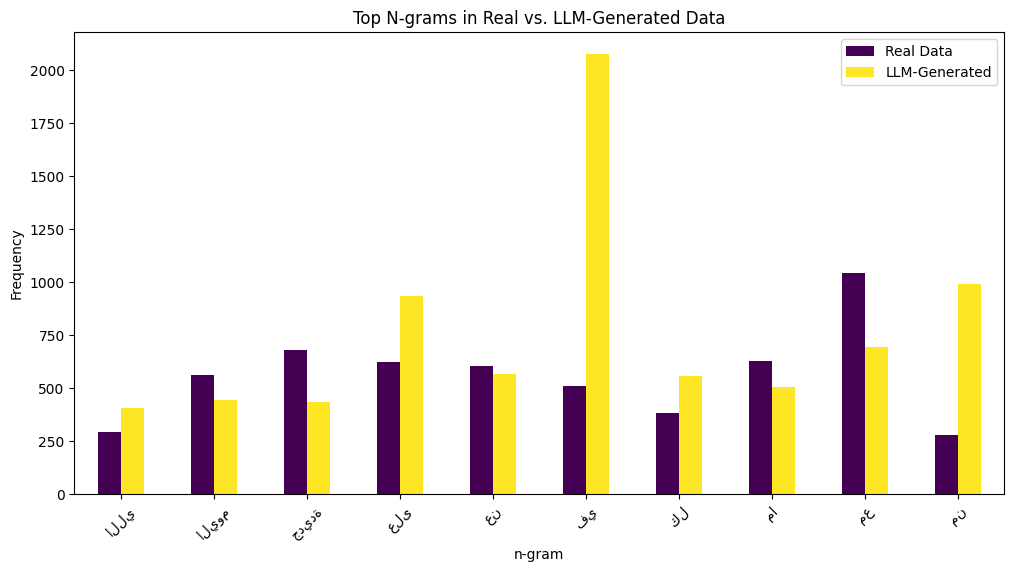

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

# Unigram and Bigram Analysis for Real and LLM-generated Data
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=10, analyzer='word')
real_counts = vectorizer.fit_transform(real_data['sent'])
llm_counts = vectorizer.fit_transform(llm_data['Text'])

# Plotting the most common n-grams
ngram_labels = vectorizer.get_feature_names_out()
real_counts_sum = np.asarray(real_counts.sum(axis=0)).flatten()
llm_counts_sum = np.asarray(llm_counts.sum(axis=0)).flatten()

df_ngram = pd.DataFrame({
    'n-gram': ngram_labels,
    'Real Data': real_counts_sum,
    'LLM-Generated': llm_counts_sum
})

df_ngram.plot(x='n-gram', kind='bar', figsize=(12, 6), title='Top N-grams in Real vs. LLM-Generated Data', colormap='viridis')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


In [17]:
import nltk
nltk.download('averaged_perceptron_tagger')

real_entities = real_data['sent'].apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))
llm_entities = llm_data['Text'].apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))

# Count named entities in each dataset
real_named_entities = [entity for entities in real_entities for entity in entities if entity[1] == 'NNP']
llm_named_entities = [entity for entities in llm_entities for entity in entities if entity[1] == 'NNP']

print(f"Number of Named Entities - Real Data: {len(real_named_entities)}")
print(f"Number of Named Entities - LLM-Generated Data: {len(llm_named_entities)}")


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Sondos.Bsharat\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Number of Named Entities - Real Data: 38778
Number of Named Entities - LLM-Generated Data: 65934
